# Miniproject 1 - Variant 3 #

In [2]:
# duh
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal # For signal generation + convolution
from scipy.stats import gamma # For Gamma function
from random import sample # just for a demo

%matplotlib notebook

## 1. Generation of the Stimulus Signal ##

We imaging to show the stimuli to the subject as described in the assignment paper. Assume a linear activation of neurons with the presentation of the stimuli, thus, the signal created below is assumed to correspond to the actual activation of the neurons. 

*Should we consider controls?*

*"Each individual presentation lasting 2 seconds": does that mean Diracs 2 seconds apart?*

<IPython.core.display.Javascript object>


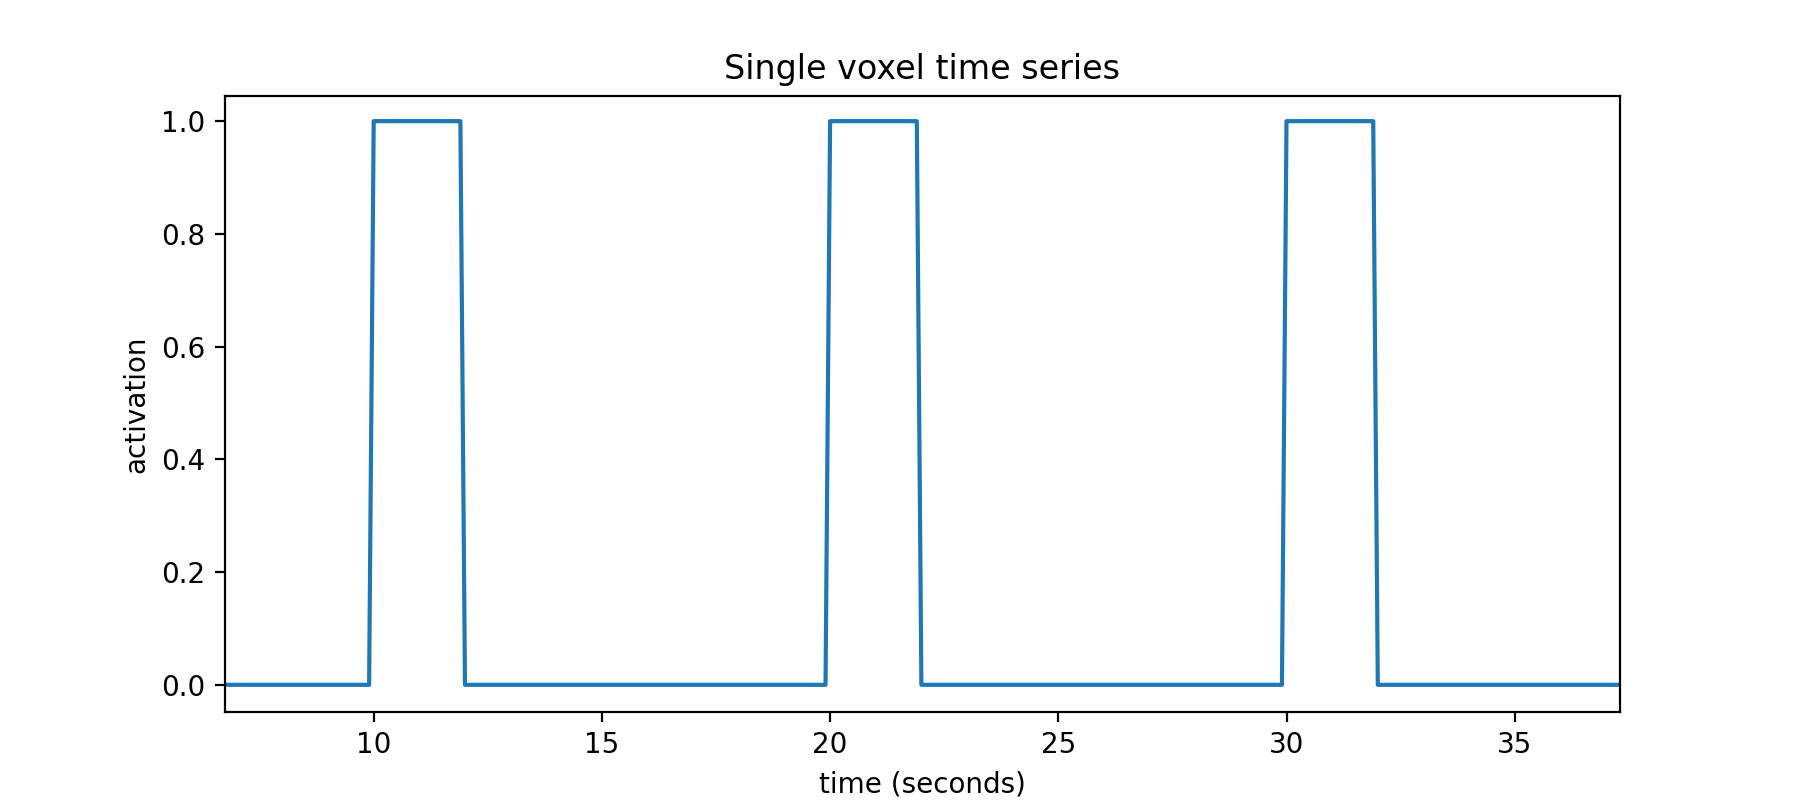

Text(0, 0.5, 'activation')

In [4]:
Ts = 10 # 1 / sampling frequency [Hz]
total_duration = 100 # [sec]
t = np.arange(0, total_duration, 1/Ts)
presentation_duration = 2 # [s]
episode_duration = 10 # [s] one stimulus + one rest (control)
neur = 0.5*(scipy.signal.square(2*np.pi*(1/episode_duration)*t, presentation_duration/episode_duration)+1)

plt.figure(figsize=(9,4))
plt.plot(t, neur)
plt.title('Single voxel time series')
plt.xlabel('time (seconds)')
plt.ylabel('activation')

In [3]:
# Explain: The function simulates a voxel response when an individual is shown a repeating series of
# images of faces for two seconds (where the amplitude is 1) followed by non-facial control images
# for two images (where there is no amplitude).

## 2. Generation of the HRF Response Function ##

We now consider the response of the blood-oxygen level (BOLD) signal.

Consider an impulse (ie Dirac impulse) activation of one neuron; as seen in class, then blood-oxygen level varies accordingly. This response of the BOLD signal forms the impulse response of the LTI system whose input is the abstracted neural activation (ie on/off) and whose output is the BOLD signal. This is called the hemoglobin (?) response function HRF. 

There is an initial phase of overcompensation or overshoot where the oxygen level is raised far above neutral level, then a second phase of undershoot where the oxygen level temporarily drops. These two phases are modelled by the shape of a gamma probability distribution. 

<IPython.core.display.Javascript object>


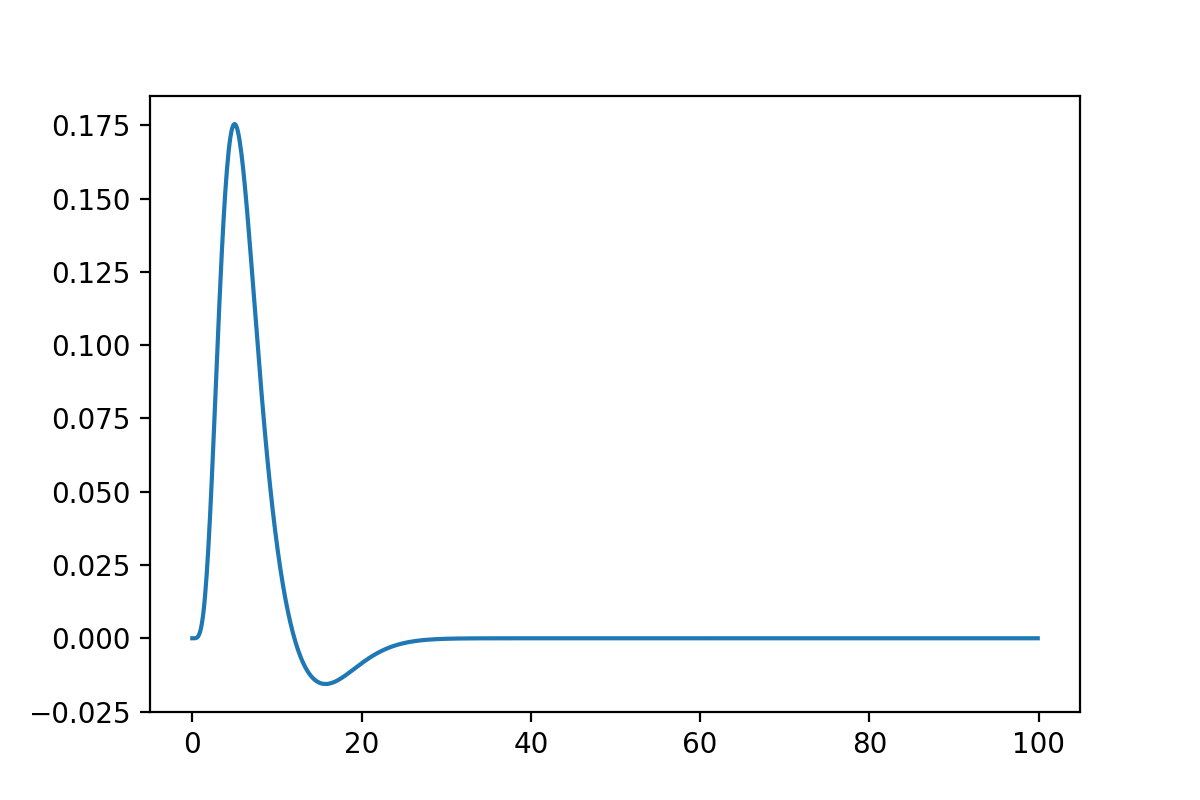

In [56]:
A = 1 # temporary (?)

alpha1 = 6
alpha2 = 16
beta1 = 1
beta2 = 1
c = 1/6

def HRF(t, A, c, alpha1, alpha2, beta1, beta2):
    h = A*(gamma.pdf(t, alpha1, scale=1/beta1)- c*gamma.pdf(t, alpha2, scale=1/beta2))
    return h

h = HRF(t, A, c, alpha1, alpha2, beta1, beta2)

plt.figure(figsize=(6,4))
plt.plot(t, h)

Note: per the documentation for the Gamma function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html), gamma.pdf(t, a, scale=1/b) is equivalent to $\frac{b^a x^{a-1}e^{b t}}{\Gamma(a)}$

Now we can obtain the measured BOLD response by convolving the simulated neural activation signal with the HRF: (mode='same' gives an output of same size as the first argument)

<IPython.core.display.Javascript object>


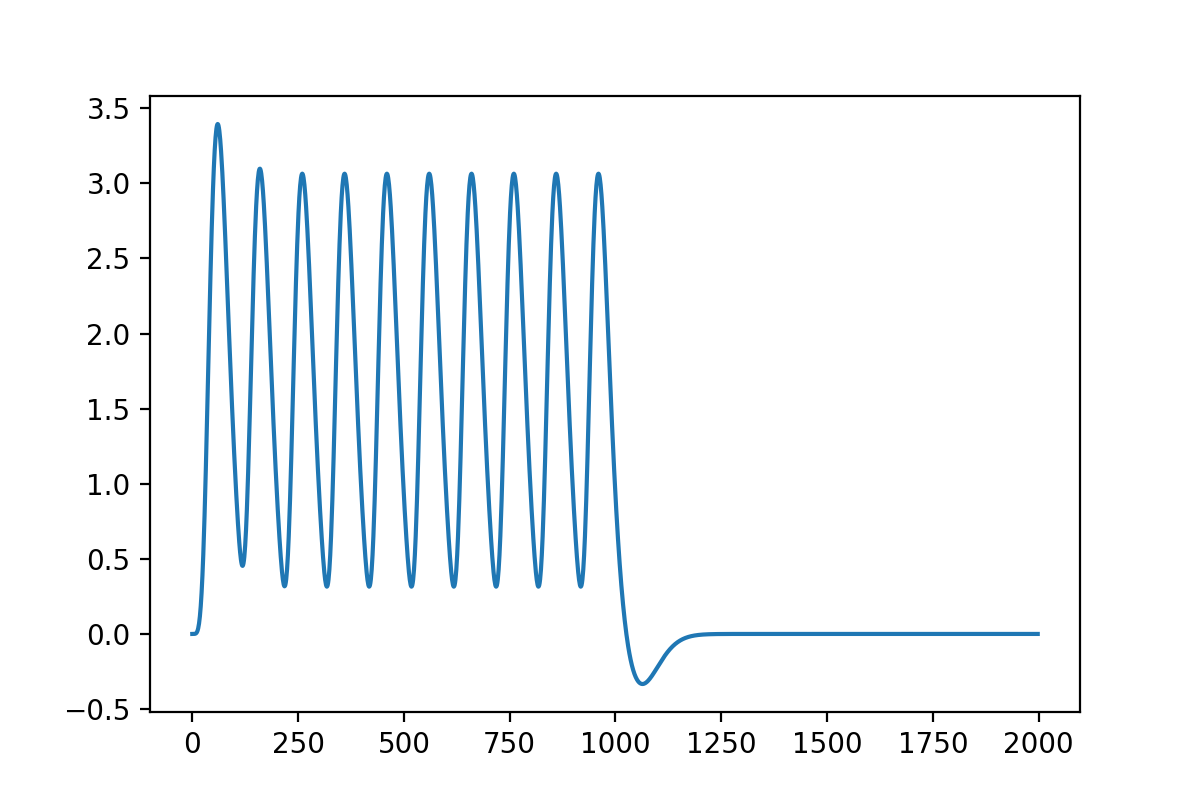

In [57]:
bold = scipy.signal.convolve(neur, h, mode='full')

plt.figure(figsize=(6,4))
plt.plot(bold)

Note that the BOLD signal is longer, and drops at the end of the measurment. For simplicity, we can crop out all parts of the signal outside of the measurement time. 

*Note that using mode="valid" on the convolution crops the output to incldue the ending*

<IPython.core.display.Javascript object>


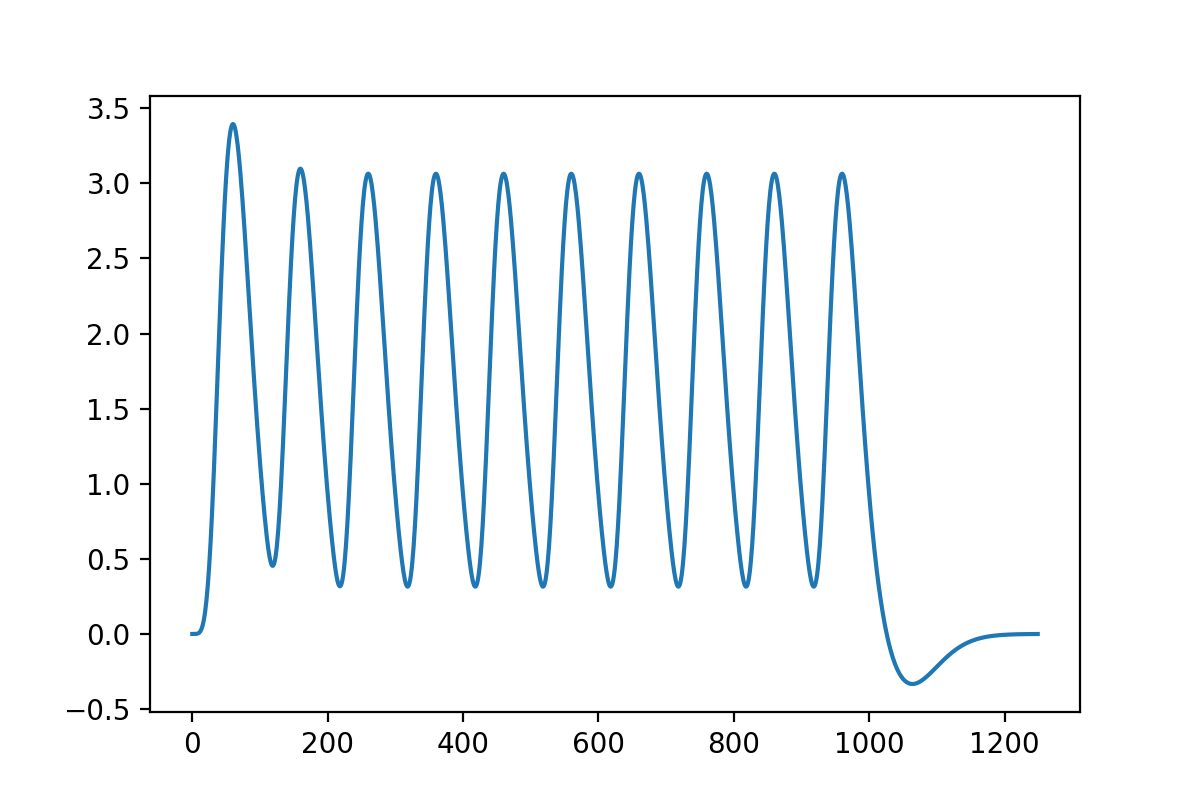

In [58]:
padding = 25 # [sec]
bold = bold[0:(total_duration+25)*Ts]

plt.figure(figsize=(6,4))
plt.plot(bold)

## 3. Observing the Effects of the alpha Parameters

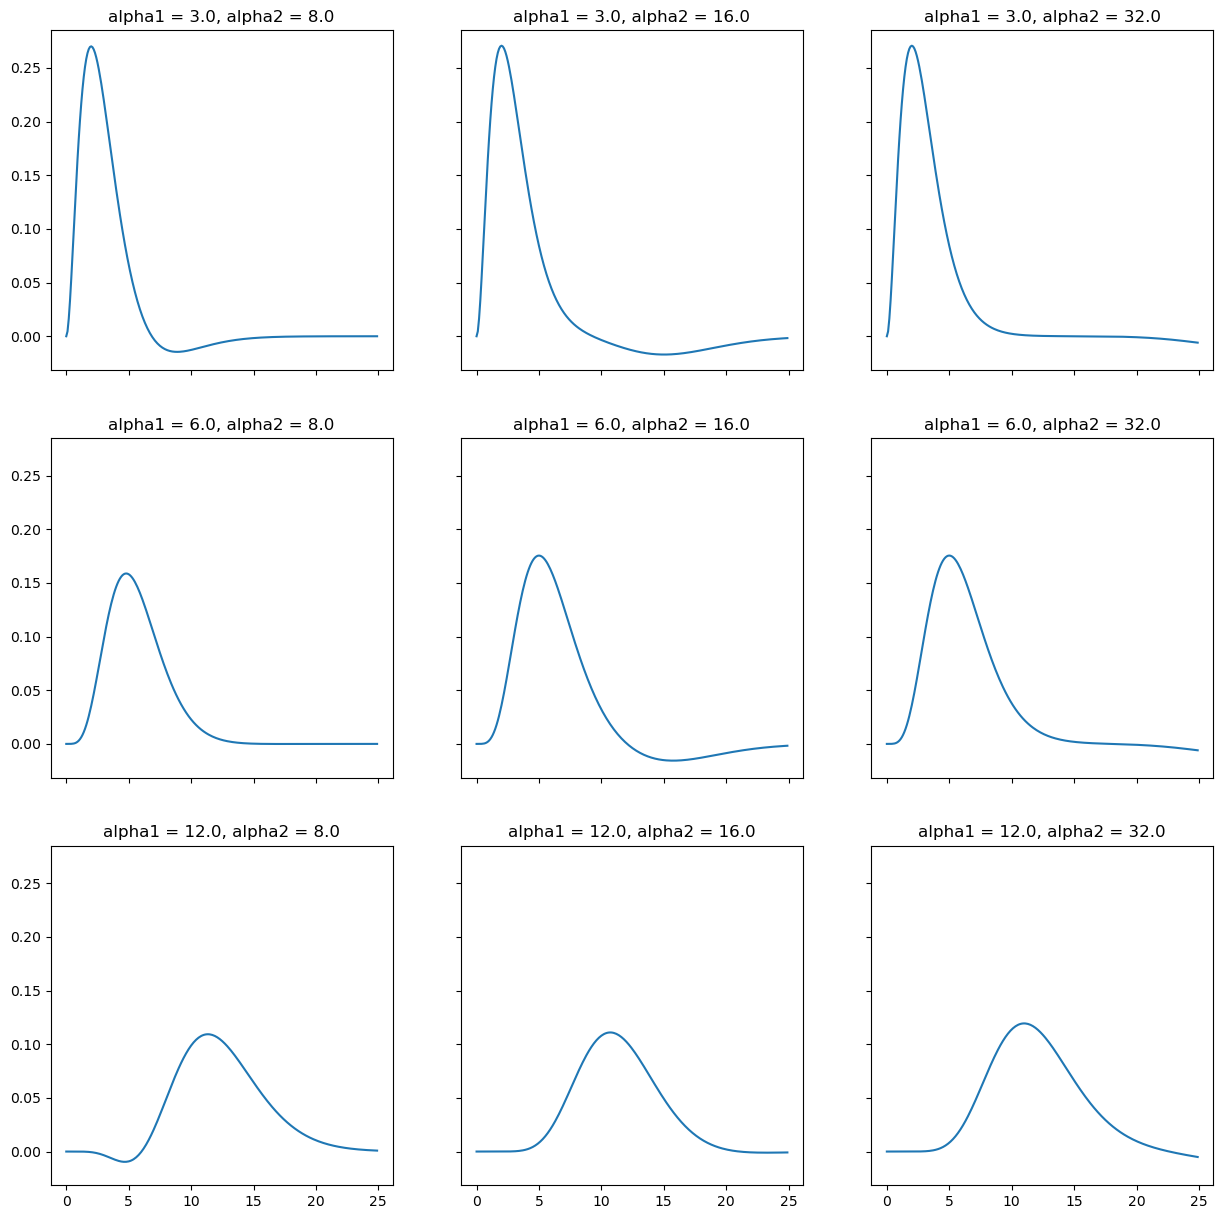

In [59]:
%matplotlib inline

alpha1s = np.array([0.5, 1, 2])*alpha1
alpha2s = np.array([0.5, 1, 2])*alpha2
t_cut = np.arange(0, 25, 1/Ts)

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i,j].plot(t_cut, HRF(t_cut, A, c, alpha1s[i], alpha2s[j], beta1, beta2))
        axs[i,j].set_title(f"alpha1 = {alpha1s[i]}, alpha2 = {alpha2s[j]}")
#plt.close()        

## 4. Adding Gaussian Noise ##

In [60]:
sigma = 0.15 # std dev of the noise added
t = np.arange(0, 125, 1/Ts)
bold_noisy = bold + np.random.normal(0, sigma, t.shape)

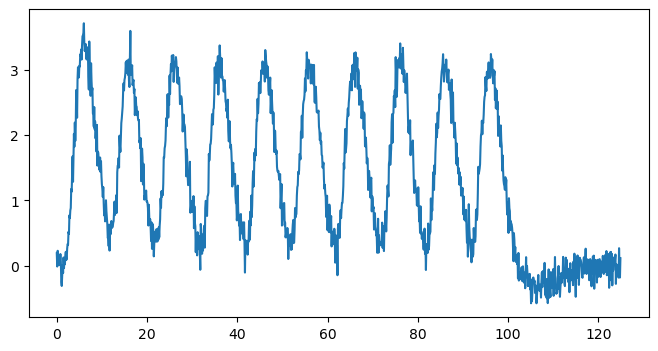

In [61]:
plt.figure(figsize=(8,4))
plt.plot(t, bold_noisy)

## 5. Construction of the GLM ##

Construct a GLM where y is the simulated BOLD voxel time-series. Then we attempt to interpolate the neuron activation from a matrix X of basis vectors. Each column corresponds to a HRF function convolved with a Dirac at the moment of a presentation. 

In [62]:
import pandas as pd
y = bold_noisy
# active = np.array([1,0,0,0]*25)
# rest = np.array([0,1,1,1]*25)

neur_rest = -0.5*(scipy.signal.square(2*np.pi*(1/episode_duration)*t, presentation_duration/episode_duration)+1)+1
rest = scipy.signal.convolve(neur_rest, h, mode='full')
rest = rest[:1250]
constant = np.ones(1250)

X = pd.DataFrame(data={'active':bold, 'rest':rest, 'constant':constant})

In [63]:
X.shape

(1250, 3)

In [64]:
X

,active,rest,constant
0,0.000000e+00,0.000000,1.0
1,7.540312e-08,0.000000,1.0
2,2.258685e-06,0.000000,1.0
3,1.726025e-05,0.000000,1.0
4,7.446090e-05,0.000000,1.0
...,...,...,...
1245,-5.533804e-04,5.987665,1.0
1246,-5.236999e-04,5.895855,1.0
1247,-4.955454e-04,5.809070,1.0
1248,-4.688424e-04,5.727741,1.0


## 6. Solving the GLM ##

Using OLS estimator; using the formula as seen in class:
$$ \bar{\beta} = (X^TX)^{-1}X^Ty $$

In [68]:
X_ = X.to_numpy()
beta = np.linalg.inv(X_.T@X_)@X_.T@y
y_hat = X_@beta

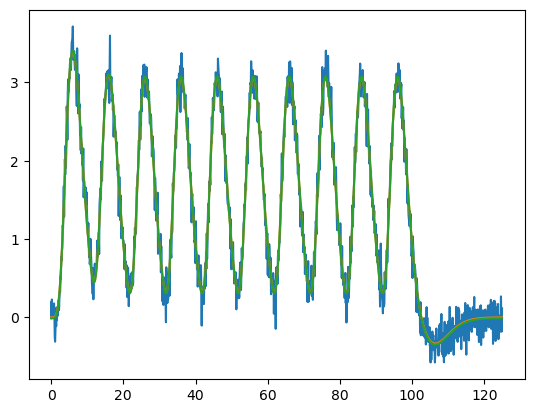

In [69]:
plt.plot(t,y)
plt.plot(t, bold)
plt.plot(t,y_hat)

In [70]:
print(np.sum(np.abs(bold-y_hat))) # residual (error)

8.335787862229425


*Correct to do bold and not y???*

## 7. Hypothesis Test on the Regressors ##

In [72]:
print(beta)

[ 1.00663691e+00  2.47271006e-04 -1.18839582e-02]


In [88]:
# Show if any are statistically different from zero using T-Test.
import scipy.stats as stats
print(stats.ttest_ind(X_*beta[0],y))
print(stats.ttest_ind(X_*beta[1],y))
print(stats.ttest_ind(X_*beta[2],y))

Ttest_indResult(statistic=array([  0.22551786,  87.21014942, -10.02895955]), pvalue=array([8.21594884e-01, 0.00000000e+00, 3.10860677e-23]))
Ttest_indResult(statistic=array([-41.05770143, -41.01896182, -41.06024416]), pvalue=array([4.56619672e-282, 1.18087173e-281, 4.29009756e-282]))
Ttest_indResult(statistic=array([-41.55360342, -43.41130797, -41.4343017 ]), pvalue=array([2.34849717e-287, 2.90563020e-307, 4.40772747e-286]))


/var/folders/dr/kjc3b_yd36x3c60mhmh6_wy00000gn/T/ipykernel_67823/2490634308.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(X_*beta[0],y))
/var/folders/dr/kjc3b_yd36x3c60mhmh6_wy00000gn/T/ipykernel_67823/2490634308.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(X_*beta[1],y))
/var/folders/dr/kjc3b_yd36x3c60mhmh6_wy00000gn/T/ipykernel_67823/2490634308.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(X_*beta[2],y))


## 8. Graphical Representation of the Design Matrix ##

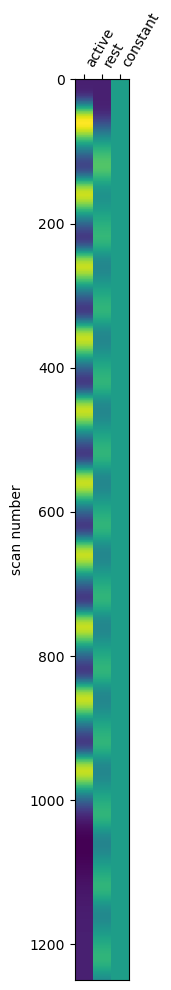

In [65]:
from nilearn.plotting import plot_design_matrix

plot_design_matrix(X) # insert pd dataframe
plt.show()

where active = face and rest = object

## 9. Repeat for a Real Dataset (Optional) ##

In [ ]:
# this is where we would find the region of the brain being activated 